In [1]:
import consultas as cst
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   

In [ ]:
#QUERY QUE TRAE LOS USUARIOS DEL ULTIMO ENDING QUE CORRERA EL MODELO , CAMBIAR EL PROCESOCODIGO  PARA ENTRENAR
query=f'''
SELECT A.SUBSCRIBER_ID,
       A.MOVIMIENTO_NOMBRE 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
WHERE A.PERIODO_PROCESO_CODIGO=TO_NUMBER(TO_CHAR(SYSTIMESTAMP,'YYYYMM'))
AND A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_NOMBRE IN ('ACTIVACION','PERMANECE')
AND A.ESTADO='Active'
AND A.SUBSCRIBER_ID IN (
            SELECT SUBSCRIBER_ID FROM ( 
                    SELECT B.*,
                    ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE RN=1
            AND   PREDICCION=0
)
'''

In [ ]:
#QUERY QUE NOS DA LA ULTIMA RECARGA QUE HA TENIDO CADA SUBSCRIBER DEL FILTRO 
query=f'''
SELECT B.SUBSCRIBER_ID,
       B.TIEMPO_RECARGA_DK AS TIEMPO_ULTIMA_RECARGA,
       B.VALOR_CARGA AS VALOR_ULTIMA_RECARGA,
       B.FECHA_RECARGA AS ULTIMA_RECARGA
FROM (
SELECT B.*,
       ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_RECARGA DESC) AS RN  
FROM DWH_BODEGA_WOM.FCT_RECARGAS B
WHERE B.SUBSCRIBER_ID IN (
        SELECT A.SUBSCRIBER_ID 
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE A.PERIODO_PROCESO_CODIGO=TO_NUMBER(TO_CHAR(SYSTIMESTAMP,'YYYYMM'))
        AND A.SERVICIO='Prepaid'
        AND A.MOVIMIENTO_NOMBRE IN ('ACTIVACION','PERMANECE')
        AND A.ESTADO='Active'
        AND A.SUBSCRIBER_ID IN (
                SELECT SUBSCRIBER_ID FROM ( 
                        SELECT B.*,
                        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
                        FROM AGG_DL_PJ_QUALITY B )
                WHERE RN=1
                AND   PREDICCION=0
        )
) )B
WHERE B.RN=1


'''


In [ ]:
#QUERY QUE UNE LAS 2 TABLAS ANTERIORES Y LO DA PARA LA ACTUAL 

query=f'''
WITH BASE AS 
(SELECT /*PARALLEL(8)*/
        A.SUBSCRIBER_ID,
        A.MOVIMIENTO_NOMBRE 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
WHERE A.PERIODO_PROCESO_CODIGO=TO_NUMBER(TO_CHAR(SYSTIMESTAMP,'YYYYMM'))
AND A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_NOMBRE IN ('ACTIVACION','PERMANECE')
AND A.ESTADO='Active'
AND A.SUBSCRIBER_ID IN (
            SELECT SUBSCRIBER_ID FROM ( 
                    SELECT B.*,
                    ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE RN=1
            AND   PREDICCION=0
)),
RECARGAS AS (
SELECT /*PARALLEL(8)*/
       B.SUBSCRIBER_ID,
       B.TIEMPO_RECARGA_DK AS TIEMPO_ULTIMA_RECARGA,
       B.VALOR_CARGA AS VALOR_ULTIMA_RECARGA,
       B.FECHA_RECARGA AS ULTIMA_RECARGA
FROM (
SELECT /*PARALLEL(8)*/
       B.*,
       ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_RECARGA DESC) AS RN  
FROM DWH_BODEGA_WOM.FCT_RECARGAS B
WHERE B.SUBSCRIBER_ID IN (
        SELECT A.SUBSCRIBER_ID 
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE A.PERIODO_PROCESO_CODIGO=TO_NUMBER(TO_CHAR(SYSTIMESTAMP,'YYYYMM'))
        AND A.SERVICIO='Prepaid'
        AND A.MOVIMIENTO_NOMBRE IN ('ACTIVACION','PERMANECE')
        AND A.ESTADO='Active'
        AND A.SUBSCRIBER_ID IN (
                SELECT SUBSCRIBER_ID FROM ( 
                        SELECT B.*,
                        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
                        FROM AGG_DL_PJ_QUALITY B )
                WHERE RN=1
                AND   PREDICCION=0
        )
) )B
WHERE B.RN=1
)

SELECT  /*PARALLEL(8)*/
        A.*,
        B.*,
        CASE 
            WHEN B.ULTIMA_RECARGA >= SYSDATE-5 THEN TO_NUMBER(TO_CHAR(B.ULTIMA_RECARGA,'YYYYMMDD'))
            ELSE TO_NUMBER(TO_CHAR(B.ULTIMA_RECARGA+ROUND((SYSDATE-B.ULTIMA_RECARGA)/5,0)*5,'YYYYMMDD')) 
        END AS INICIO_CICLO,
        CASE 
            WHEN B.ULTIMA_RECARGA = SYSDATE-5  THEN B.ULTIMA_RECARGA
        END AS FECHA_PRED,
        ROUND((SYSDATE-B.ULTIMA_RECARGA)/5,0) AS CICLOS 
        
FROM BASE A 
JOIN RECARGAS B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID 
'''

In [3]:
#COGEMOS EL QUERY ANTERIOR Y SEGMENTAMOS PARA ENTRENAR CON FECHA 20221120 NOVIEMBRE
#QUERY QUE UNE LAS 2 TABLAS ANTERIORES Y LO DA PARA LA ACTUAL 
#LA IDEA DESPUES ES PEGARLE MAS DIAS CON LA MISMA LOGICA QUE SE ESTA MANEJANDO PARA TENER MAS BASE DE ENTRENAMIENTO 


query=f'''
WITH BASE AS 
(SELECT /*PARALLEL(8)*/
        A.SUBSCRIBER_ID,
        A.MOVIMIENTO_NOMBRE 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
WHERE A.PERIODO_PROCESO_CODIGO=202212
AND A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_NOMBRE IN ('ACTIVACION','PERMANECE')
AND A.ESTADO='Active'
AND A.SUBSCRIBER_ID IN (
            SELECT SUBSCRIBER_ID FROM ( 
                    SELECT B.*,
                    ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE RN=1
            AND   PREDICCION=0
)),
RECARGAS AS (
SELECT /*PARALLEL(8)*/
       B.SUBSCRIBER_ID,
       B.TIEMPO_RECARGA_DK AS TIEMPO_ULTIMA_RECARGA,
       B.VALOR_CARGA AS VALOR_ULTIMA_RECARGA,
       B.FECHA_RECARGA AS ULTIMA_RECARGA
FROM (
SELECT /*PARALLEL(8)*/
       B.*,
       ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_RECARGA DESC) AS RN  
FROM DWH_BODEGA_WOM.FCT_RECARGAS B
WHERE   B.TIEMPO_RECARGA_DK<=20221210
        AND B.SUBSCRIBER_ID IN (
        SELECT A.SUBSCRIBER_ID 
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE A.PERIODO_PROCESO_CODIGO=202212
        AND A.SERVICIO='Prepaid'
        AND A.MOVIMIENTO_NOMBRE IN ('ACTIVACION','PERMANECE')
        AND A.ESTADO='Active'
        AND A.SUBSCRIBER_ID IN (
                SELECT SUBSCRIBER_ID FROM ( 
                        SELECT B.*,
                        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
                        FROM AGG_DL_PJ_QUALITY B )
                WHERE RN=1
                AND   PREDICCION=0
        )
) )B
WHERE B.RN=1
)
SELECT * FROM  (
SELECT  /*PARALLEL(8)*/
        A.MOVIMIENTO_NOMBRE,
        B.*,
        CASE
            WHEN A.MOVIMIENTO_NOMBRE='ACTIVACION' THEN 1 
            ELSE 0 
        END AS GROSS_PERMA,
        CASE 
            WHEN B.TIEMPO_ULTIMA_RECARGA >= 20221210-5 THEN B.TIEMPO_ULTIMA_RECARGA
            ELSE TO_NUMBER(TO_CHAR(B.ULTIMA_RECARGA+ROUND((TO_DATE(TO_CHAR(20221210), 'YYYY/MM/DD')-B.ULTIMA_RECARGA)/5,0)*5 -5,'YYYYMMDD')) 
        END AS INICIO_CICLO,
        20221120 AS FECHA_PRED,
        ROUND((TO_DATE(TO_CHAR(20221210), 'YYYY/MM/DD')-B.ULTIMA_RECARGA)/5,0)-1 AS CICLOS 
FROM BASE A 
JOIN RECARGAS B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID 
)G WHERE INICIO_CICLO=20221210-5


'''
base_entreno=cst.consulta(query)
#esta base contiene variables de ciclos , valor ultima_recarga y si es gross o permanece 

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
base_entreno

,MOVIMIENTO_NOMBRE,SUBSCRIBER_ID,TIEMPO_ULTIMA_RECARGA,VALOR_ULTIMA_RECARGA,ULTIMA_RECARGA,GROSS_PERMA,INICIO_CICLO,FECHA_PRED,CICLOS
0,PERMANECE,192555940,20221110,5000.0,2022-11-10 05:04:55,0,20221115,20221120,1
1,PERMANECE,192561029,20220728,20000.0,2022-07-28 12:43:07,0,20221115,20221120,22
2,PERMANECE,192564517,20221031,1000.0,2022-10-31 10:19:12,0,20221115,20221120,3
3,PERMANECE,192565958,20220529,10000.0,2022-05-29 18:03:07,0,20221115,20221120,34
4,PERMANECE,192568865,20220429,1000.0,2022-04-29 13:21:15,0,20221115,20221120,40
...,...,...,...,...,...,...,...,...,...
89794,ACTIVACION,2322133509,20221115,11000.0,2022-11-15 10:31:03,1,20221115,20221120,0
89795,ACTIVACION,2322704597,20221115,21000.0,2022-11-15 05:41:53,1,20221115,20221120,0
89796,ACTIVACION,2323794938,20221115,7500.0,2022-11-15 09:18:19,1,20221115,20221120,0
89797,ACTIVACION,2323971099,20221115,3000.0,2022-11-15 11:52:20,1,20221115,20221120,0


In [3]:
#variables trafico cantidad llamadas, duracion y dias con llamadas
query=f'''
SELECT  SUBSCRIBER_ID,
        SUM(CANT_CALLS) AS CANTIDAD_LLAMADAS,
        SUM(DURACION_CALLS) AS DURACION_LLAMADAS,
        COUNT(DISTINCT(PERIODO_PROCESO_CODIGO)) AS DIAS_LLAMADAS
FROM AGG_DL_VOICE
WHERE PERIODO_PROCESO_CODIGO BETWEEN 20221120-5 AND 20221120-1
      AND SERVICIO='Prepaid'
      AND SENTIDO='SALIENTE'
GROUP BY SUBSCRIBER_ID
'''
trafico_voz=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [12]:
trafico_voz

,SUBSCRIBER_ID,CANTIDAD_LLAMADAS,DURACION_LLAMADAS,DIAS_LLAMADAS
0,1219870659,34,3514,5
1,1298179263,82,5158,4
2,1152600421,7,14,4
3,1264715031,28,3947,5
4,1251445306,8,392,3
...,...,...,...,...
393710,1293291268,1,241,1
393711,2198889914,1,2,1
393712,1115419060,1,42,1
393713,1187608154,1,3,1


In [4]:
#variables de trafico de datos 
query=f'''
SELECT SUBSCRIBER_ID,
       ROUND(SUM(BYTES_TOTALES)/1024/1024,0) AS MB_CONSUMIDAS ,
       COUNT(DISTINCT(PERIODO_PROCESO_CODIGO)) AS DIAS_NAV 
FROM AGG_DL_DATA
WHERE PERIODO_PROCESO_CODIGO BETWEEN 20221120-5 AND 20221120-1
      AND SERVICIO='Prepaid'
GROUP BY SUBSCRIBER_ID
'''
trafico_datos=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [13]:
trafico_datos

,SUBSCRIBER_ID,MB_CONSUMIDAS,DIAS_NAV
0,1197525006,6498,5
1,1113201029,1455,5
2,1235935723,1579,5
3,1136663039,1637,5
4,1252239458,83,5
...,...,...,...
421911,1164984447,0,1
421912,1339635865,58,1
421913,1293291268,0,1
421914,1207001924,0,1


In [9]:
#agregar la variable binaria de paquete y los dias restantes de este pegandole el nombre 
query=f'''
SELECT C.*,
       ROUND(TO_DATE(TO_CHAR(20221120), 'YYYY/MM/DD')-C.FECHA_VENCE,0) AS DIAS_VENCIDO
FROM (
SELECT A.SUBSCRIBER_ID,
       A.FECHA_RECARGA,
       A.PAQUETE_NOMBRE,
       COALESCE(B.DURACION,3),
       A.FECHA_RECARGA+COALESCE(B.DURACION,3) AS FECHA_VENCE, 
       ROW_NUMBER() OVER(PARTITION BY A.SUBSCRIBER_ID ORDER BY A.FECHA_RECARGA DESC ) AS RN
FROM DWH_BODEGA_WOM.FCT_PAQUETES A
JOIN PAQUETES B ON A.PAQUETE_NOMBRE=B.PAQUETE_NOMBRE
WHERE TIEMPO_PAQUETE_DK<=20221120-5
      AND SERVICIO='Prepaid'
    ) C WHERE RN=1
'''
paquetes_dur=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [8]:
paquetes_dur

,SUBSCRIBER_ID,FECHA_RECARGA,PAQUETE_NOMBRE,DURACION,FECHA_VENCE,RN,DIAS_VENCIDO
0,1.925497e+08,2021-05-06 14:13:00,Paquete Mixto 3D,3.0,2021-05-09 14:13:00,1,559.0
1,1.925519e+08,2022-01-11 15:25:32,Paquete Mixto 10D,10.0,2022-01-21 15:25:32,1,302.0
2,1.925536e+08,2022-02-09 16:10:29,LDI 5.000 pesos,NaN,NaT,1,NaN
3,1.925536e+08,2021-12-07 09:28:03,Paquete Mixto 1D,1.0,2021-12-08 09:28:03,1,347.0
4,1.925541e+08,2022-10-04 18:17:06,MIXTO_Paquete 30D _9GB,30.0,2022-11-03 18:17:06,1,16.0
...,...,...,...,...,...,...,...
1475463,2.324137e+09,2022-11-14 21:43:02,MIXTO_Paquete 7D _1.5GB,7.0,2022-11-21 21:43:02,1,-2.0
1475464,2.324399e+09,2022-10-16 00:24:13,MIXTO_Paquete 3D _500MB,3.0,2022-10-19 00:24:13,1,32.0
1475465,2.324423e+09,2022-10-21 10:45:08,Paquete prepago WB APPs_2022,NaN,NaT,1,NaN
1475466,2.326293e+09,2022-11-02 19:28:29,Paquete prepago WB APPs_2022,NaN,NaT,1,NaN


In [7]:
paquetes_dur.groupby('DURACION')[['SUBSCRIBER_ID']].count()

,SUBSCRIBER_ID
DURACION,
1.0,142868
2.0,2
3.0,424805
7.0,586998
10.0,61048
15.0,113104
30.0,122537
90.0,9375


In [6]:
#variable "y" para medir los resultados es mirar si recargo entre el 20 y 25 nov
query=f'''
SELECT SUBSCRIBER_ID,
       CASE
          WHEN COUNT(*)>=1 THEN 1 ELSE 0 
       END AS RECARGO
FROM DWH_BODEGA_WOM.FCT_RECARGAS
WHERE TIEMPO_RECARGA_DK BETWEEN 20221120+1 AND 20221120+5 
GROUP BY SUBSCRIBER_ID
'''
var_y=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [10]:
paquetes_dur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475468 entries, 0 to 1475467
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   SUBSCRIBER_ID           1475467 non-null  float64       
 1   FECHA_RECARGA           1475468 non-null  datetime64[ns]
 2   PAQUETE_NOMBRE          1475468 non-null  object        
 3   COALESCE(B.DURACION,3)  1475468 non-null  int64         
 4   FECHA_VENCE             1475468 non-null  datetime64[ns]
 5   RN                      1475468 non-null  int64         
 6   DIAS_VENCIDO            1475468 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 78.8+ MB


In [11]:
trafico_datos['SUBSCRIBER_ID'] = trafico_datos['SUBSCRIBER_ID'].astype('int64')
trafico_voz['SUBSCRIBER_ID'] = trafico_voz['SUBSCRIBER_ID'].astype('int64')


In [12]:
df_insumos=base_entreno.merge(trafico_voz,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos=df_insumos.merge(trafico_datos,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos=df_insumos.merge(paquetes_dur,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos=df_insumos.merge(var_y,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')

In [13]:
df_insumos

,MOVIMIENTO_NOMBRE,SUBSCRIBER_ID,TIEMPO_ULTIMA_RECARGA,VALOR_ULTIMA_RECARGA,ULTIMA_RECARGA,GROSS_PERMA,INICIO_CICLO,FECHA_PRED,CICLOS,CANTIDAD_LLAMADAS,...,DIAS_LLAMADAS,MB_CONSUMIDAS,DIAS_NAV,FECHA_RECARGA,PAQUETE_NOMBRE,"COALESCE(B.DURACION,3)",FECHA_VENCE,RN,DIAS_VENCIDO,RECARGO
0,PERMANECE,192555940,20221110,5000.0,2022-11-10 05:04:55,0,20221115,20221120,1,9.0,...,3.0,1.0,5.0,2022-08-22 16:25:50,Paquete Mixto 10D,10.0,2022-09-01 16:25:50,1.0,79.0,NaN
1,PERMANECE,192561029,20220728,20000.0,2022-07-28 12:43:07,0,20221115,20221120,22,NaN,...,NaN,NaN,NaN,2022-07-28 12:40:53,Paquete Mixto 30D,30.0,2022-08-27 12:40:53,1.0,84.0,NaN
2,PERMANECE,192564517,20221031,1000.0,2022-10-31 10:19:12,0,20221115,20221120,3,NaN,...,NaN,682.0,4.0,2022-10-21 00:30:56,MIXTO_Paquete 3D _500MB,3.0,2022-10-24 00:30:56,1.0,27.0,NaN
3,PERMANECE,192565958,20220529,10000.0,2022-05-29 18:03:07,0,20221115,20221120,34,NaN,...,NaN,NaN,NaN,2022-05-29 18:03:07,Paquete 15D_Mixto,15.0,2022-06-13 18:03:07,1.0,159.0,NaN
4,PERMANECE,192568865,20220429,1000.0,2022-04-29 13:21:15,0,20221115,20221120,40,1.0,...,1.0,0.0,2.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89794,ACTIVACION,2322133509,20221115,11000.0,2022-11-15 10:31:03,1,20221115,20221120,0,31.0,...,5.0,403.0,5.0,2022-11-15 10:32:15,MIXTO_Paquete 15D _4GB,15.0,2022-11-30 10:32:15,1.0,-10.0,1.0
89795,ACTIVACION,2322704597,20221115,21000.0,2022-11-15 05:41:53,1,20221115,20221120,0,52.0,...,5.0,846.0,5.0,2022-11-15 05:41:53,MIXTO_Paquete 30D _9GB,30.0,2022-12-15 05:41:53,1.0,-25.0,NaN
89796,ACTIVACION,2323794938,20221115,7500.0,2022-11-15 09:18:19,1,20221115,20221120,0,6.0,...,2.0,455.0,5.0,2022-11-15 09:18:19,MIXTO_Paquete 10D _2.5GB,10.0,2022-11-25 09:18:19,1.0,-5.0,NaN
89797,ACTIVACION,2323971099,20221115,3000.0,2022-11-15 11:52:20,1,20221115,20221120,0,4.0,...,2.0,1602.0,5.0,2022-11-15 11:52:19,Paquete Datos 3D,3.0,2022-11-18 11:52:19,1.0,2.0,NaN


In [14]:
df_insumos=df_insumos.fillna(0)

In [15]:
df_insumos

,MOVIMIENTO_NOMBRE,SUBSCRIBER_ID,TIEMPO_ULTIMA_RECARGA,VALOR_ULTIMA_RECARGA,ULTIMA_RECARGA,GROSS_PERMA,INICIO_CICLO,FECHA_PRED,CICLOS,CANTIDAD_LLAMADAS,...,DIAS_LLAMADAS,MB_CONSUMIDAS,DIAS_NAV,FECHA_RECARGA,PAQUETE_NOMBRE,"COALESCE(B.DURACION,3)",FECHA_VENCE,RN,DIAS_VENCIDO,RECARGO
0,PERMANECE,192555940,20221110,5000.0,2022-11-10 05:04:55,0,20221115,20221120,1,9.0,...,3.0,1.0,5.0,2022-08-22 16:25:50,Paquete Mixto 10D,10.0,2022-09-01 16:25:50,1.0,79.0,0.0
1,PERMANECE,192561029,20220728,20000.0,2022-07-28 12:43:07,0,20221115,20221120,22,0.0,...,0.0,0.0,0.0,2022-07-28 12:40:53,Paquete Mixto 30D,30.0,2022-08-27 12:40:53,1.0,84.0,0.0
2,PERMANECE,192564517,20221031,1000.0,2022-10-31 10:19:12,0,20221115,20221120,3,0.0,...,0.0,682.0,4.0,2022-10-21 00:30:56,MIXTO_Paquete 3D _500MB,3.0,2022-10-24 00:30:56,1.0,27.0,0.0
3,PERMANECE,192565958,20220529,10000.0,2022-05-29 18:03:07,0,20221115,20221120,34,0.0,...,0.0,0.0,0.0,2022-05-29 18:03:07,Paquete 15D_Mixto,15.0,2022-06-13 18:03:07,1.0,159.0,0.0
4,PERMANECE,192568865,20220429,1000.0,2022-04-29 13:21:15,0,20221115,20221120,40,1.0,...,1.0,0.0,2.0,0,0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89794,ACTIVACION,2322133509,20221115,11000.0,2022-11-15 10:31:03,1,20221115,20221120,0,31.0,...,5.0,403.0,5.0,2022-11-15 10:32:15,MIXTO_Paquete 15D _4GB,15.0,2022-11-30 10:32:15,1.0,-10.0,1.0
89795,ACTIVACION,2322704597,20221115,21000.0,2022-11-15 05:41:53,1,20221115,20221120,0,52.0,...,5.0,846.0,5.0,2022-11-15 05:41:53,MIXTO_Paquete 30D _9GB,30.0,2022-12-15 05:41:53,1.0,-25.0,0.0
89796,ACTIVACION,2323794938,20221115,7500.0,2022-11-15 09:18:19,1,20221115,20221120,0,6.0,...,2.0,455.0,5.0,2022-11-15 09:18:19,MIXTO_Paquete 10D _2.5GB,10.0,2022-11-25 09:18:19,1.0,-5.0,0.0
89797,ACTIVACION,2323971099,20221115,3000.0,2022-11-15 11:52:20,1,20221115,20221120,0,4.0,...,2.0,1602.0,5.0,2022-11-15 11:52:19,Paquete Datos 3D,3.0,2022-11-18 11:52:19,1.0,2.0,0.0


In [16]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [41]:
df_insumos.columns

Index(['MOVIMIENTO_NOMBRE', 'SUBSCRIBER_ID', 'TIEMPO_ULTIMA_RECARGA',
       'VALOR_ULTIMA_RECARGA', 'ULTIMA_RECARGA', 'GROSS_PERMA', 'INICIO_CICLO',
       'FECHA_PRED', 'CICLOS', 'CANTIDAD_LLAMADAS', 'DURACION_LLAMADAS',
       'DIAS_LLAMADAS', 'MB_CONSUMIDAS', 'DIAS_NAV', 'RECARGO'],
      dtype='object')

In [17]:
X_prueba=df_insumos[['VALOR_ULTIMA_RECARGA','GROSS_PERMA','CICLOS', 'CANTIDAD_LLAMADAS', 'DURACION_LLAMADAS',
       'DIAS_LLAMADAS', 'MB_CONSUMIDAS', 'DIAS_NAV','DIAS_VENCIDO']]

In [18]:
y_port = df_insumos['RECARGO']

In [19]:
X_port=X_prueba
X_train, X_test, y_train, y_test = train_test_split(X_port, y_port, train_size=0.7, random_state=13)

In [20]:
random_forest = RandomForestClassifier(random_state=12)

In [21]:
smote = SMOTE(random_state=13)
X_smote, y_smote = smote.fit_resample(X_train, y_train.ravel())

In [22]:
random_forest.fit(X_smote, y_smote)

RandomForestClassifier(random_state=12)

In [23]:
y_pred = random_forest.predict(X_test)

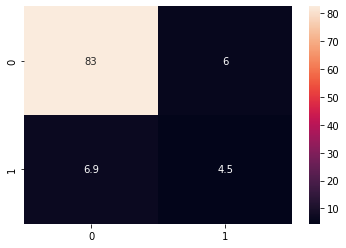

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred)/len(y_test)*100, annot=True)
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93     23856
         1.0       0.43      0.39      0.41      3084

    accuracy                           0.87     26940
   macro avg       0.68      0.66      0.67     26940
weighted avg       0.87      0.87      0.87     26940



In [26]:
feature_importance = random_forest.feature_importances_
feature_names=X_port.columns
dic_feature_importance = {
                        'feature_importance':feature_importance,
                        'feature_names':feature_names }
feature_importance_DF= pd.DataFrame(dic_feature_importance).sort_values(by='feature_importance',ascending=False)
feature_importance_DF.head(25)

,feature_importance,feature_names
6,0.221232,MB_CONSUMIDAS
7,0.191542,DIAS_NAV
8,0.159383,DIAS_VENCIDO
5,0.102682,DIAS_LLAMADAS
2,0.093028,CICLOS
3,0.091967,CANTIDAD_LLAMADAS
4,0.064697,DURACION_LLAMADAS
0,0.060176,VALOR_ULTIMA_RECARGA
1,0.015293,GROSS_PERMA


In [27]:
import pickle 
# guardar el modelo
pickle.dump(random_forest, open("model_topups.pkl", "wb"))

In [29]:
#traeremos solo a los que el modelo evalua otro dia y que solo tengan 0 ciclos 
base_prueba=base_entreno[base_entreno['CICLOS']<=3]

In [31]:
df_insumos=base_prueba.merge(trafico_voz,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos=df_insumos.merge(trafico_datos,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos=df_insumos.merge(paquetes_dur,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos=df_insumos.merge(var_y,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')

In [32]:
df_insumos=df_insumos.fillna(0)

In [33]:
X_prueba1=df_insumos[['VALOR_ULTIMA_RECARGA','GROSS_PERMA','CICLOS', 'CANTIDAD_LLAMADAS', 'DURACION_LLAMADAS',
       'DIAS_LLAMADAS', 'MB_CONSUMIDAS', 'DIAS_NAV','DIAS_VENCIDO']]

In [35]:
model = pickle.load(open("model_topups.pkl", "rb"))
prediction = pd.DataFrame(model.predict(X_prueba1))
prediction.columns = ['PREDICCION']
Y_prob=model.predict_proba(X_prueba1)
Y_prob=Y_prob[[1]]
Y_prob=Y_prob*100

In [38]:
prediction

,PREDICCION
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
36263,1.0
36264,0.0
36265,0.0
36266,0.0


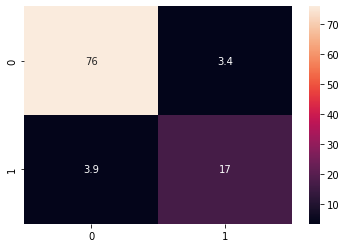

In [45]:
sns.heatmap(confusion_matrix(df_insumos['RECARGO'], prediction['PREDICCION'])/len(df_insumos)*100, annot=True)
plt.show()

In [46]:
print(classification_report(df_insumos['RECARGO'], prediction['PREDICCION']))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     28773
         1.0       0.83      0.81      0.82      7495

    accuracy                           0.93     36268
   macro avg       0.89      0.88      0.89     36268
weighted avg       0.93      0.93      0.93     36268



In [ ]:
###################################################################

In [2]:

query=f'''
WITH BASE AS 
(SELECT /*PARALLEL(8)*/
        A.SUBSCRIBER_ID,
        A.MOVIMIENTO_NOMBRE 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
WHERE A.PERIODO_PROCESO_CODIGO=202212
AND A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_NOMBRE IN ('ACTIVACION','PERMANECE')
AND A.ESTADO='Active'
AND A.SUBSCRIBER_ID IN (
            SELECT SUBSCRIBER_ID FROM ( 
                    SELECT B.*,
                    ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE RN=1
            AND   PREDICCION=0
)),
RECARGAS AS (
SELECT /*PARALLEL(8)*/
       B.SUBSCRIBER_ID,
       B.TIEMPO_RECARGA_DK AS TIEMPO_ULTIMA_RECARGA,
       B.VALOR_CARGA AS VALOR_ULTIMA_RECARGA,
       B.FECHA_RECARGA AS ULTIMA_RECARGA
FROM (
SELECT /*PARALLEL(8)*/
       B.*,
       ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_RECARGA DESC) AS RN  
FROM DWH_BODEGA_WOM.FCT_RECARGAS B
WHERE   B.TIEMPO_RECARGA_DK<=20221210
        AND B.SUBSCRIBER_ID IN (
        SELECT A.SUBSCRIBER_ID 
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE A.PERIODO_PROCESO_CODIGO=202212
        AND A.SERVICIO='Prepaid'
        AND A.MOVIMIENTO_NOMBRE IN ('ACTIVACION','PERMANECE')
        AND A.ESTADO='Active'
        AND A.SUBSCRIBER_ID IN (
                SELECT SUBSCRIBER_ID FROM ( 
                        SELECT B.*,
                        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
                        FROM AGG_DL_PJ_QUALITY B )
                WHERE RN=1
                AND   PREDICCION=0
        )
) )B
WHERE B.RN=1
)
SELECT * FROM  (
SELECT  /*PARALLEL(8)*/
        A.MOVIMIENTO_NOMBRE,
        B.*,
        CASE
            WHEN A.MOVIMIENTO_NOMBRE='ACTIVACION' THEN 1 
            ELSE 0 
        END AS GROSS_PERMA,
        CASE 
            WHEN B.TIEMPO_ULTIMA_RECARGA >= 20221210-5 THEN B.TIEMPO_ULTIMA_RECARGA
            ELSE TO_NUMBER(TO_CHAR(B.ULTIMA_RECARGA+ROUND((TO_DATE(TO_CHAR(20221210), 'YYYY/MM/DD')-B.ULTIMA_RECARGA)/5,0)*5 -5,'YYYYMMDD')) 
        END AS INICIO_CICLO,
        20221210 AS FECHA_PRED,
        ROUND((TO_DATE(TO_CHAR(20221210), 'YYYY/MM/DD')-B.ULTIMA_RECARGA)/5,0)-1 AS CICLOS 
FROM BASE A 
JOIN RECARGAS B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID 
)G WHERE INICIO_CICLO=20221210-5
   AND CICLOS<=6 


'''
base_entreno=cst.consulta(query)
#esta base contiene variables de ciclos , valor ultima_recarga y si es gross o permanece 

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [3]:
base_entreno.to_csv('base_entreno.csv')

In [4]:
query=f'''
WITH BASE AS 
(SELECT /*PARALLEL(8)*/
        A.SUBSCRIBER_ID,
        A.MOVIMIENTO_NOMBRE 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
WHERE A.PERIODO_PROCESO_CODIGO=202212
AND A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_NOMBRE IN ('ACTIVACION','PERMANECE')
AND A.ESTADO='Active'
AND A.SUBSCRIBER_ID IN (
            SELECT SUBSCRIBER_ID FROM ( 
                    SELECT B.*,
                    ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE RN=1
            AND   PREDICCION=0
)),
RECARGAS AS (
SELECT /*PARALLEL(8)*/
       B.SUBSCRIBER_ID,
       B.TIEMPO_RECARGA_DK AS TIEMPO_ULTIMA_RECARGA,
       B.VALOR_CARGA AS VALOR_ULTIMA_RECARGA,
       B.FECHA_RECARGA AS ULTIMA_RECARGA
FROM (
SELECT /*PARALLEL(8)*/
       B.*,
       ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_RECARGA DESC) AS RN  
FROM DWH_BODEGA_WOM.FCT_RECARGAS B
WHERE   B.TIEMPO_RECARGA_DK<=20221220
        AND B.SUBSCRIBER_ID IN (
        SELECT A.SUBSCRIBER_ID 
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE A.PERIODO_PROCESO_CODIGO=202212
        AND A.SERVICIO='Prepaid'
        AND A.MOVIMIENTO_NOMBRE IN ('ACTIVACION','PERMANECE')
        AND A.ESTADO='Active'
        AND A.SUBSCRIBER_ID IN (
                SELECT SUBSCRIBER_ID FROM ( 
                        SELECT B.*,
                        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
                        FROM AGG_DL_PJ_QUALITY B )
                WHERE RN=1
                AND   PREDICCION=0
        )
) )B
WHERE B.RN=1
)
SELECT * FROM  (
SELECT  /*PARALLEL(8)*/
        A.MOVIMIENTO_NOMBRE,
        B.*,
        CASE
            WHEN A.MOVIMIENTO_NOMBRE='ACTIVACION' THEN 1 
            ELSE 0 
        END AS GROSS_PERMA,
        CASE 
            WHEN B.TIEMPO_ULTIMA_RECARGA >= 20221220-5 THEN B.TIEMPO_ULTIMA_RECARGA
            ELSE TO_NUMBER(TO_CHAR(B.ULTIMA_RECARGA+ROUND((TO_DATE(TO_CHAR(20221220), 'YYYY/MM/DD')-B.ULTIMA_RECARGA)/5,0)*5 -5,'YYYYMMDD')) 
        END AS INICIO_CICLO,
        20221220 AS FECHA_PRED,
        ROUND((TO_DATE(TO_CHAR(20221220), 'YYYY/MM/DD')-B.ULTIMA_RECARGA)/5,0)-1 AS CICLOS 
FROM BASE A 
JOIN RECARGAS B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID 
)G WHERE INICIO_CICLO=20221220-5
   AND CICLOS<=6 


'''
base_entreno2=cst.consulta(query)
#esta base contiene variables de ciclos , valor ultima_recarga y si es gross o permanece Y ES DEL 21

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
base_entreno2.to_csv('base_entreno2.csv')

In [4]:
base_entreno

,MOVIMIENTO_NOMBRE,SUBSCRIBER_ID,TIEMPO_ULTIMA_RECARGA,VALOR_ULTIMA_RECARGA,ULTIMA_RECARGA,GROSS_PERMA,INICIO_CICLO,FECHA_PRED,CICLOS
0,PERMANECE,192555940,20221110,5000,2022-11-10 05:04:55,0,20221115,20221120,1
1,PERMANECE,192564517,20221031,1000,2022-10-31 10:19:12,0,20221115,20221120,3
2,PERMANECE,1112631048,20221026,3000,2022-10-26 14:05:04,0,20221115,20221120,4
3,PERMANECE,1112632338,20221110,5000,2022-11-10 11:25:16,0,20221115,20221120,1
4,PERMANECE,1112633973,20221115,3500,2022-11-15 05:35:51,0,20221115,20221120,0
...,...,...,...,...,...,...,...,...,...
40503,ACTIVACION,2322133509,20221115,11000,2022-11-15 10:31:03,1,20221115,20221120,0
40504,ACTIVACION,2322704597,20221115,21000,2022-11-15 05:41:53,1,20221115,20221120,0
40505,ACTIVACION,2323794938,20221115,7500,2022-11-15 09:18:19,1,20221115,20221120,0
40506,ACTIVACION,2323971099,20221115,3000,2022-11-15 11:52:20,1,20221115,20221120,0


In [5]:
base_entreno2

,MOVIMIENTO_NOMBRE,SUBSCRIBER_ID,TIEMPO_ULTIMA_RECARGA,VALOR_ULTIMA_RECARGA,ULTIMA_RECARGA,GROSS_PERMA,INICIO_CICLO,FECHA_PRED,CICLOS
0,PERMANECE,192561164,20221027,20000,2022-10-27 18:45:41,0,20221116,20221121,4
1,ACTIVACION,192579830,20221111,11000,2022-11-11 16:29:54,1,20221116,20221121,1
2,ACTIVACION,192580966,20221101,5000,2022-11-01 10:54:12,1,20221116,20221121,3
3,PERMANECE,1112632079,20221111,2000,2022-11-11 12:34:31,0,20221116,20221121,1
4,PERMANECE,1112632454,20221027,2000,2022-10-27 12:53:19,0,20221116,20221121,4
...,...,...,...,...,...,...,...,...,...
33135,ACTIVACION,2319371374,20221116,5500,2022-11-16 17:12:19,1,20221116,20221121,0
33136,ACTIVACION,2322677026,20221116,5500,2022-11-16 12:32:59,1,20221116,20221121,0
33137,ACTIVACION,2324575327,20221116,43000,2022-11-16 08:51:47,1,20221116,20221121,0
33138,ACTIVACION,2326250031,20221106,13000,2022-11-06 13:15:41,1,20221116,20221121,2


In [6]:
#variables trafico cantidad llamadas, duracion y dias con llamadas
query=f'''
SELECT  SUBSCRIBER_ID,
        SUM(CANT_CALLS) AS CANTIDAD_LLAMADAS,
        SUM(DURACION_CALLS) AS DURACION_LLAMADAS,
        COUNT(DISTINCT(PERIODO_PROCESO_CODIGO)) AS DIAS_LLAMADAS
FROM AGG_DL_VOICE
WHERE PERIODO_PROCESO_CODIGO BETWEEN 20221210-5 AND 20221210-1
      AND SERVICIO='Prepaid'
      AND SENTIDO='SALIENTE'
      AND SUBSCRIBER_ID IN (SELECT SUBSCRIBER_ID FROM ( 
                    SELECT *
                     
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE PREDICCION=0)
GROUP BY SUBSCRIBER_ID
'''
trafico_voz=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [7]:
trafico_voz.to_csv('trafico_voz.csv')

In [8]:
#variables trafico cantidad llamadas, duracion y dias con llamadas
query=f'''
SELECT  SUBSCRIBER_ID,
        SUM(CANT_CALLS) AS CANTIDAD_LLAMADAS,
        SUM(DURACION_CALLS) AS DURACION_LLAMADAS,
        COUNT(DISTINCT(PERIODO_PROCESO_CODIGO)) AS DIAS_LLAMADAS
FROM AGG_DL_VOICE
WHERE PERIODO_PROCESO_CODIGO BETWEEN 20221220-5 AND 20221220-1
      AND SERVICIO='Prepaid'
      AND SENTIDO='SALIENTE'
      AND SUBSCRIBER_ID IN (SELECT SUBSCRIBER_ID FROM ( 
                    SELECT *
                     
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE PREDICCION=0)
GROUP BY SUBSCRIBER_ID
'''
trafico_voz2=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [9]:
trafico_voz2.to_csv('trafico_voz2.csv')

In [10]:
#variables de trafico de datos 
query=f'''
SELECT SUBSCRIBER_ID,
       ROUND(SUM(BYTES_TOTALES)/1024/1024,0) AS MB_CONSUMIDAS ,
       COUNT(DISTINCT(PERIODO_PROCESO_CODIGO)) AS DIAS_NAV 
FROM AGG_DL_DATA
WHERE PERIODO_PROCESO_CODIGO BETWEEN 20221210-5 AND 20221210-1
      AND SERVICIO='Prepaid'
      AND SUBSCRIBER_ID IN (SELECT SUBSCRIBER_ID FROM ( 
                    SELECT *
                     
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE PREDICCION=0)
GROUP BY SUBSCRIBER_ID
'''
trafico_datos=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [11]:
trafico_datos.to_csv('trafico_datos.csv')

In [12]:
#variables de trafico de datos 
query=f'''
SELECT SUBSCRIBER_ID,
       ROUND(SUM(BYTES_TOTALES)/1024/1024,0) AS MB_CONSUMIDAS ,
       COUNT(DISTINCT(PERIODO_PROCESO_CODIGO)) AS DIAS_NAV 
FROM AGG_DL_DATA
WHERE PERIODO_PROCESO_CODIGO BETWEEN 20221220-5 AND 20221220-1
      AND SERVICIO='Prepaid'
      AND SUBSCRIBER_ID IN (SELECT SUBSCRIBER_ID FROM ( 
                    SELECT *
                     
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE PREDICCION=0)
GROUP BY SUBSCRIBER_ID
'''
trafico_datos2=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [13]:
trafico_datos2.to_csv('trafico_datos2.csv')

In [14]:
#agregar la variable binaria de paquete y los dias restantes de este pegandole el nombre 
query=f'''
SELECT C.*,
       ROUND(TO_DATE(TO_CHAR(20221210), 'YYYY/MM/DD')-C.FECHA_VENCE,0) AS DIAS_VENCIDO
FROM (
SELECT A.SUBSCRIBER_ID,
       A.FECHA_RECARGA,
       A.PAQUETE_NOMBRE,
       COALESCE(B.DURACION,3),
       A.FECHA_RECARGA+COALESCE(B.DURACION,3) AS FECHA_VENCE, 
       ROW_NUMBER() OVER(PARTITION BY A.SUBSCRIBER_ID ORDER BY A.FECHA_RECARGA DESC ) AS RN
FROM DWH_BODEGA_WOM.FCT_PAQUETES A
JOIN PAQUETES B ON A.PAQUETE_NOMBRE=B.PAQUETE_NOMBRE
WHERE TIEMPO_PAQUETE_DK<=20221210-5
      AND SERVICIO='Prepaid'
      AND SUBSCRIBER_ID IN (SELECT SUBSCRIBER_ID FROM ( 
                    SELECT *
                     
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE PREDICCION=0)
    ) C WHERE RN=1
'''
paquetes_dur=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [15]:
paquetes_dur.to_csv('paquetes_dur.csv')

In [16]:
#agregar la variable binaria de paquete y los dias restantes de este pegandole el nombre 
query=f'''
SELECT C.*,
       ROUND(TO_DATE(TO_CHAR(20221220), 'YYYY/MM/DD')-C.FECHA_VENCE,0) AS DIAS_VENCIDO
FROM (
SELECT A.SUBSCRIBER_ID,
       A.FECHA_RECARGA,
       A.PAQUETE_NOMBRE,
       COALESCE(B.DURACION,3),
       A.FECHA_RECARGA+COALESCE(B.DURACION,3) AS FECHA_VENCE, 
       ROW_NUMBER() OVER(PARTITION BY A.SUBSCRIBER_ID ORDER BY A.FECHA_RECARGA DESC ) AS RN
FROM DWH_BODEGA_WOM.FCT_PAQUETES A
JOIN PAQUETES B ON A.PAQUETE_NOMBRE=B.PAQUETE_NOMBRE
WHERE TIEMPO_PAQUETE_DK<=20221220-5
      AND SERVICIO='Prepaid'
      AND SUBSCRIBER_ID IN (SELECT SUBSCRIBER_ID FROM ( 
                    SELECT *
                     
                    FROM AGG_DL_PJ_QUALITY B )
            WHERE PREDICCION=0)
    ) C WHERE RN=1
'''
paquetes_dur2=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [17]:
paquetes_dur2.to_csv('paquetes_dur2.csv')

In [18]:
#variable "y" para medir los resultados es mirar si recargo entre el 20 y 25 nov
query=f'''
SELECT SUBSCRIBER_ID,
       CASE
          WHEN COUNT(*)>=1 THEN 1 ELSE 0 
       END AS RECARGO
FROM DWH_BODEGA_WOM.FCT_RECARGAS
WHERE TIEMPO_RECARGA_DK BETWEEN 20221210+1 AND 20221210+5 
GROUP BY SUBSCRIBER_ID
'''
var_y=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [19]:
var_y.to_csv('var_y.csv')

In [20]:
#variable "y" para medir los resultados es mirar si recargo entre el 20 y 25 nov
query=f'''
SELECT SUBSCRIBER_ID,
       CASE
          WHEN COUNT(*)>=1 THEN 1 ELSE 0 
       END AS RECARGO
FROM DWH_BODEGA_WOM.FCT_RECARGAS
WHERE TIEMPO_RECARGA_DK BETWEEN 20221220+1 AND 20221220+5 
GROUP BY SUBSCRIBER_ID
'''
var_y2=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [21]:
var_y2.to_csv('var_y2.csv')

In [22]:
base_entreno=pd.read_csv('base_entreno.csv', sep=',')
trafico_voz=pd.read_csv('trafico_voz.csv', sep=',')
trafico_datos=pd.read_csv('trafico_datos.csv', sep=',')
paquetes_dur=pd.read_csv('paquetes_dur.csv', sep=',')
var_y=pd.read_csv('var_y.csv', sep=',')
#
base_entreno2=pd.read_csv('base_entreno2.csv', sep=',')
trafico_voz2=pd.read_csv('trafico_voz2.csv', sep=',')
trafico_datos2=pd.read_csv('trafico_datos2.csv', sep=',')
paquetes_dur2=pd.read_csv('paquetes_dur2.csv', sep=',')
var_y2=pd.read_csv('var_y2.csv', sep=',')

In [23]:
trafico_datos['SUBSCRIBER_ID'] = trafico_datos['SUBSCRIBER_ID'].astype('int64')
trafico_voz['SUBSCRIBER_ID'] = trafico_voz['SUBSCRIBER_ID'].astype('int64')
trafico_datos2['SUBSCRIBER_ID'] = trafico_datos2['SUBSCRIBER_ID'].astype('int64')
trafico_voz2['SUBSCRIBER_ID'] = trafico_voz2['SUBSCRIBER_ID'].astype('int64')


In [24]:
df_insumos=base_entreno.merge(trafico_voz,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos=df_insumos.merge(trafico_datos,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos=df_insumos.merge(paquetes_dur,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos=df_insumos.merge(var_y,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
#para el 21
df_insumos2=base_entreno2.merge(trafico_voz2,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos2=df_insumos2.merge(trafico_datos2,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos2=df_insumos2.merge(paquetes_dur2,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos2=df_insumos2.merge(var_y2,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')

C:\Users\HP EliteBook 840 G3\AppData\Local\Temp\ipykernel_16248\2007828303.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_insumos=df_insumos.merge(paquetes_dur,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
C:\Users\HP EliteBook 840 G3\AppData\Local\Temp\ipykernel_16248\2007828303.py:8: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_insumos2=df_insumos2.merge(paquetes_dur2,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')


In [25]:
df_insumos=df_insumos.fillna(0)
df_insumos2=df_insumos2.fillna(0)

In [25]:
resultado=pd.concat([df_insumos,df_insumos2])

In [26]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [27]:
X_prueba=resultado[['VALOR_ULTIMA_RECARGA','GROSS_PERMA','CICLOS', 'CANTIDAD_LLAMADAS', 'DURACION_LLAMADAS',
       'DIAS_LLAMADAS', 'MB_CONSUMIDAS', 'DIAS_NAV','DIAS_VENCIDO']]

In [28]:
y_port = resultado['RECARGO']

In [29]:
X_port=X_prueba
X_train, X_test, y_train, y_test = train_test_split(X_port, y_port, train_size=0.7, random_state=13)


In [30]:
random_forest = RandomForestClassifier(random_state=12)

In [31]:
smote = SMOTE(random_state=13)
X_smote, y_smote = smote.fit_resample(X_train, y_train.ravel())

In [32]:
random_forest.fit(X_smote, y_smote)

RandomForestClassifier(random_state=12)

In [33]:
y_pred = random_forest.predict(X_test)

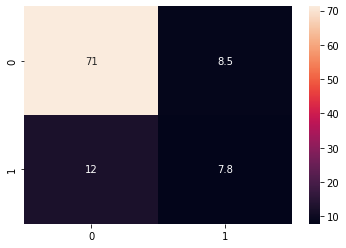

In [34]:
sns.heatmap(confusion_matrix(y_test, y_pred)/len(y_test)*100, annot=True)
plt.show()

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87     20187
         1.0       0.48      0.39      0.43      5129

    accuracy                           0.79     25316
   macro avg       0.67      0.64      0.65     25316
weighted avg       0.78      0.79      0.78     25316



In [36]:
feature_importance = random_forest.feature_importances_
feature_names=X_port.columns
dic_feature_importance = {
                        'feature_importance':feature_importance,
                        'feature_names':feature_names }
feature_importance_DF= pd.DataFrame(dic_feature_importance).sort_values(by='feature_importance',ascending=False)
feature_importance_DF.head(25)

,feature_importance,feature_names
6,0.235066,MB_CONSUMIDAS
8,0.185711,DIAS_VENCIDO
7,0.142984,DIAS_NAV
5,0.105094,DIAS_LLAMADAS
4,0.104592,DURACION_LLAMADAS
3,0.100089,CANTIDAD_LLAMADAS
0,0.071110,VALOR_ULTIMA_RECARGA
2,0.035403,CICLOS
1,0.019950,GROSS_PERMA


In [23]:
df_insumos2.columns

Index(['Unnamed: 0_x', 'MOVIMIENTO_NOMBRE', 'SUBSCRIBER_ID',
       'TIEMPO_ULTIMA_RECARGA', 'VALOR_ULTIMA_RECARGA', 'ULTIMA_RECARGA',
       'GROSS_PERMA', 'INICIO_CICLO', 'FECHA_PRED', 'CICLOS', 'Unnamed: 0_y',
       'CANTIDAD_LLAMADAS', 'DURACION_LLAMADAS', 'DIAS_LLAMADAS',
       'Unnamed: 0_x', 'MB_CONSUMIDAS', 'DIAS_NAV', 'Unnamed: 0_y',
       'FECHA_RECARGA', 'PAQUETE_NOMBRE', 'COALESCE(B.DURACION,3)',
       'FECHA_VENCE', 'RN', 'DIAS_VENCIDO', 'RECARGO'],
      dtype='object')

In [34]:
df_insumos2[['SUBSCRIBER_ID','PAQUETE_NOMBRE','DIAS_VENCIDO']]

,SUBSCRIBER_ID,PAQUETE_NOMBRE,DIAS_VENCIDO
0,192555940,Paquete Mixto 10D,84.0
1,192564517,MIXTO_Paquete 3D _500MB,32.0
2,1112632338,Paquete Datos 7D,8.0
3,1112633973,MIXTO_Paquete 3D _500MB,7.0
4,1112634342,MIXTO_Paquete 7D _1.5GB,12.0
...,...,...,...
45140,2324641944,MIXTO_Paquete 7D _1.5GB,-2.0
45141,2324775153,MIXTO_Paquete 3D _500MB,2.0
45142,2327213982,MIXTO_Paquete 7D _1.5GB,-2.0
45143,2327812965,MIXTO_Paquete 10D _2.5GB,-6.0


In [37]:
import pickle 
# guardar el modelo
pickle.dump(random_forest, open("model_topups_v2.1.pkl", "wb"))

In [26]:
import pickle
X_prueba1=df_insumos[['VALOR_ULTIMA_RECARGA','GROSS_PERMA','CICLOS', 'CANTIDAD_LLAMADAS', 'DURACION_LLAMADAS',
       'DIAS_LLAMADAS', 'MB_CONSUMIDAS', 'DIAS_NAV','DIAS_VENCIDO']]
X_prueba2=df_insumos2[['VALOR_ULTIMA_RECARGA','GROSS_PERMA','CICLOS', 'CANTIDAD_LLAMADAS', 'DURACION_LLAMADAS',
       'DIAS_LLAMADAS', 'MB_CONSUMIDAS', 'DIAS_NAV','DIAS_VENCIDO']]

In [38]:
base_entreno2.to_csv('base_entreno2.csv')
trafico_voz2.to_csv('trafico_voz2.csv')
trafico_datos2.to_csv('trafico_datos2.csv')
paquetes_dur2.to_csv('paquetes_dur2.csv')

In [3]:
base_entreno2=pd.read_csv('base_entreno2.csv', sep=',')
trafico_voz2=pd.read_csv('trafico_voz2.csv', sep=',')
trafico_datos2=pd.read_csv('trafico_datos2.csv', sep=',')
paquetes_dur2=pd.read_csv('paquetes_dur2.csv', sep=',')

In [11]:
import pickle
model = pickle.load(open("model_topups.pkl", "rb"))
prediction = pd.DataFrame(model.predict(X_prueba1))
prediction.columns = ['PREDICCION']
Y_prob=model.predict_proba(X_prueba1)
Y_prob=Y_prob[[1]]
Y_prob=Y_prob*100

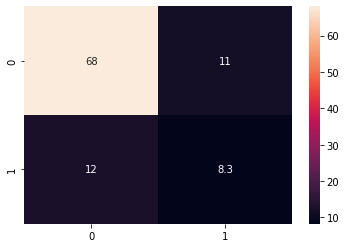

In [13]:
sns.heatmap(confusion_matrix(df_insumos2['RECARGO'], prediction['PREDICCION'])/len(df_insumos2)*100, annot=True)
plt.show()

In [15]:
print(classification_report(df_insumos2['RECARGO'], prediction['PREDICCION']))

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85     35857
         1.0       0.42      0.40      0.41      9288

    accuracy                           0.76     45145
   macro avg       0.63      0.63      0.63     45145
weighted avg       0.76      0.76      0.76     45145



In [27]:
model = pickle.load(open("model_topups_v2.1.pkl", "rb"))
prediction = pd.DataFrame(model.predict(X_prueba1))
prediction.columns = ['PREDICCION']
Y_prob=model.predict_proba(X_prueba1)
Y_prob=Y_prob[[1]]
Y_prob=Y_prob*100

In [32]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

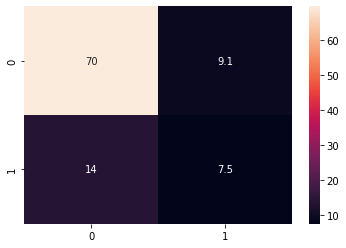

In [33]:
sns.heatmap(confusion_matrix(df_insumos['RECARGO'], prediction['PREDICCION'])/len(df_insumos)*100, annot=True)
plt.show()

In [35]:
print(classification_report(df_insumos['RECARGO'], prediction['PREDICCION']))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86     31807
         1.0       0.45      0.35      0.40      8615

    accuracy                           0.77     40422
   macro avg       0.64      0.62      0.63     40422
weighted avg       0.75      0.77      0.76     40422



In [36]:
model = pickle.load(open("model_topups_v2.1.pkl", "rb"))
prediction = pd.DataFrame(model.predict(X_prueba2))
prediction.columns = ['PREDICCION']
Y_prob=model.predict_proba(X_prueba2)
Y_prob=Y_prob[[1]]
Y_prob=Y_prob*100

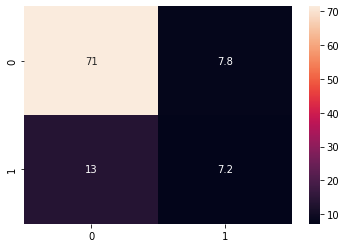

In [37]:
sns.heatmap(confusion_matrix(df_insumos2['RECARGO'], prediction['PREDICCION'])/len(df_insumos2)*100, annot=True)
plt.show()

In [38]:
print(classification_report(df_insumos2['RECARGO'], prediction['PREDICCION']))

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87     31546
         1.0       0.48      0.35      0.40      8213

    accuracy                           0.79     39759
   macro avg       0.66      0.62      0.64     39759
weighted avg       0.77      0.79      0.77     39759



In [39]:
len(df_insumos2)

38257

array([[85., 15.]])